# Alpha and Smart Beta

In [8]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import datetime as dt


from matplotlib import style
import matplotlib as mpl
import matplotlib.font_manager as fm

style.use('seaborn-whitegrid')

font_dirs = ['Font', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'Lato'

# Set colors
my_colors = {'DBlue':'#424f64', 'LBlue':'#a4afc0', 'BrBlue':'#85c7f2', 'DGrey':'#4c4c4c', 'MGrey':'#636363', 
             'DRed':'#961e19', 'LGrey':'#d1d1d1'}

import warnings
warnings.filterwarnings('ignore')



## CAPM

This blog post is an extension of the one on Efficient Frontier.

We looked at the Efficient Frontier and calculated the Tangency Portfolio and constructed the Security Market Line (SML).

It is easy to see that the SML can be described by a linear equation:


$$
\begin{align*}
\\R_p &= R_f + \beta (R_m - R_f) + \epsilon,\quad where
\\
\\R_p &- expected\space return\space of\space the\space portfolio\space or\space stock
\\R_f &- risk\space free\space rate\space
\\R_m &- expected\space return\space of\space the\space market\space portfolio\space
\end{align*}
$$

In the case of the SML, the market portfolio was represented by the Tangency Portfolio.
In fact, this equation represents the key equation of the Capital Asset Pricing Model (CAPM). This model was built upon Harry Markowitz’s (1952) work and suggested by a number of scholars working independently, but it is most often attributed to William F. Sharpe (1964).

In practice, when analyzing stock returns, analysts usually use a broad market index, i.e., S&P500, as a proxy of the market return ($R_m$).

This framework allows us to look at the stock/portfolio return from the point of view of the risk premium. We can say that the expected return is determined by:

- the risk-free rate ($R_f$), 
- the Equity Premium ($R_m - R_f$), 
- the measure of the correlation/exposure of the portfolio to the market ($\beta$), 
- and finally, by an idiosyncratic risk of a certain stock/portfolio ($\epsilon$).

The introduction of the CAPM made the life of asset managers a bit harder. From the analytical framework it is clear, that “beating the market” can be achieved in three ways:

1) Increasing the exposure to market (𝛽 > 1), if the market grows. But by doing so, a manager increases the risk of downfall if the market suddenly declines.

2) Timing the market, i.e., increasing or decreasing 𝛽, based on market expectations.

3) Finding idiosyncratic risks (𝜖) that pay off.

We can transform the CAPM equation into an equation that describes the sources of the portfolio income as:


$$
\begin{align*}
\\R_p - R_f &= \alpha + \beta (R_m - R_f)
\end{align*}
$$

Here, $\alpha$ is a measure of a manager's skill to either time the market or to select companies based on their idiosyncratic risks. Clearly, the managers that just use high market exposure (high $\beta$) should not be rewarded extra for basically providing a market exposure. Therefore, for some time the term “beta” became an almost derogatory term in asset management circles. 


## Multi-factor models (Smart-beta)

The attitude changed somewhat after Fama and French (1992) observed that the idiosyncratic risk ($\epsilon$) can be further dissected into other types of risks inherent for stocks. This way the equation above is transormed into:

$$
\begin{align*}
\\R_p - R_f &= \alpha + \beta (R_m - R_f) + \sum{\beta R_{factors}},\quad where\\
\\ R_{factors} &- expected\space returns\space of\space risk\space factors
\end{align*}
$$

Fama and French created risk factors as long/short portfolios of stocks exhibiting certain characteristics. The simple way to think about it is that to create the portfolios we can divide the universe of stocks into two halves based on characteristics (e.g., small stocks vs. large stocks) and create a certain factor by subtracting returns of one portfolio from another. In practice, Fama and French had a more complicated way of constructing the portfolio composition 
(see http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_bench_factor.html for more information).

In their original paper (1992), they suggested two additional factors:


- High [book-to-market] minus Low (HML), and 
- Small [market capitalization] minus Big (SMB).

Later, Carhart (1997) proposed another factor (UMD – Up minus Down) to capture the tendency of well-performing stock to continue good performance by inertia, as well as badly performing stocks to keep performing badly.

Recently, Fama and French (2015) added two more factors:

- Robust (operational income) minus Weak (RMW), and
- Conservative (capital expenditure) minus Aggressive (CMA).

These are just examples of the factor approach to investing. There are other frameworks that use similar ideas, e.g., Fung and Hsieh’s (2001) seven-factor model.

The takeaway here is that the stock return has many determinants besides the broad market dynamics. However, a prudent investor can evaluate and manage their portfolio based on exposures to various risk factors.

This approach rehabilitated the notion of “beta.” Now some managers refer to the exposure to other than the market risk factors as a “smart beta,” implying that the skill of the asset manager can manifest itself in choosing risk exposure to various factors that pay off.


## Value investing via risk factors

Another important outcome is that by constructing factor portfolios, we can express our investment philosophy through a diversified portfolio of stocks.

For example, HML factor can be viewed as a classic Value vs. Growth investment approach. Value investing was suggested by Graham and Dodd (1934) and came to fame due to the success of Warren Buffet. In its simple form, Value investing implies acquiring stocks of companies with low Price-to-Book ratio. In academia, the numerator and the denominator are usually flipped, so academics talk about high Book-to-Price as an example of Value investing.

Let's see how the Fama and French’s Value portfolio performed historically.


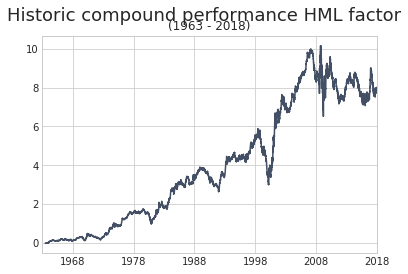

In [2]:
# Load factors
df = pd.read_csv('Data/ff_5factors.CSV', index_col=0 ,parse_dates=True) 

# Plot HML compunded
hml = (1+ df['HML']/100).cumprod() - 1
_ = plt.plot(hml, color=my_colors['DBlue'])
_ = plt.xlim('1963','2018')
_ = plt.suptitle('Historic compound performance HML factor', fontsize=18)
_ = plt.title('(1963 - 2018)', fontsize= 12)

# Save the plot
plt.savefig('Graphs\HML_performance.png', dpi=300)

Looks like the Value factors performed fairly well historically. Now, we will look at it as it pertains to market cyclicity. First, we will analyze compounded performance in growing and declining Value markets.

To do this, we adopt the approach to finding market peaks and troughs similar to Pagan et al. (2003), but with slightly different time frames:

-	We find local minima and maxima in 8-month windows both ways (prior and past the date of the observation).
-	We enforce the change of cycles (minima after maxima and vice versa)
-	We exclude cycles of less than 16 months and phases of less than 8 months unless the threshold of price increase or drop is met. We set the threshold at 20%.


In [3]:
def find_ip(data, window, min_cycle, min_phase, threshold):
    '''
    Finds inflection points in a dataset. 
    Inflection point determination is inspired by Pagan et al, 2003
    
    INPUTS:
        data - DataFrame with timeseries of stock/index closing price
        
    OUTPUTS:
        cycles - data frame with inflection points containing 
                'ip'= 1/ -1 if the point is Max or Min in the cycle
                'price' - the price of the asset 
    
    
        timeseries - data frame of of all prices. Contains 'price' and 'ip'
    
   
    '''
   
    tmp_df = pd.DataFrame({'price':data, 'ip':np.zeros(len(data))},
                           index = data.index)
    
    
    # Find local maxima and minima
    
    for i in range(window, len(data)-window):
        local_max = data.iloc[i-window : i+window].max()
        local_min = data.iloc[i-window : i+window].min()
    
        if tmp_df['price'].iloc[i] == local_max:
            tmp_df['ip'].iloc[i] = 1
        elif tmp_df['price'].iloc[i] == local_min:
            tmp_df['ip'].iloc[i] = -1 
        else:
            tmp_df['ip'].iloc[i] = 0
    
    cycles = tmp_df[tmp_df['ip']!=0]
    

    
    # remove short cycles and phases:

    cycles['date'] = pd.to_datetime(cycles.index)
    cycles['time_diff'] = cycles['date'] - cycles['date'].shift(1)
    cycles['time_diff'] = cycles['time_diff'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

    for i in range(len(cycles)-2):
        #Calculate cycle and phases length
        cycle_length = cycles['time_diff'].iloc[i+1] + cycles['time_diff'].iloc[i+2]
        phase_length = cycles['time_diff'].iloc[i+1]

        #Calculate price change
        price_chng = np.abs((cycles['price'].iloc[i+1] - cycles['price'].iloc[i]) / cycles['price'].iloc[i])  

        #Remove short cycles and phases
        if price_chng > threshold:  #Keep cycles and phases with large swings despite length
            next
        else:
            if cycle_length < min_cycle or phase_length < min_phase:
                cycles['ip'].iloc[i-1] = 0
                cycles['ip'].iloc[i] = 0


    
    #Enforce alteration

    for k in range(2):
        for i in range(len(cycles)-1):
            if cycles['ip'].iloc[i] == cycles['ip'].iloc[i+1] and cycles['ip'].iloc[i]==1:
                if cycles['price'].iloc[i] > cycles['price'].iloc[i+1]:
                    cycles['ip'].iloc[i] = 1
                    cycles['ip'].iloc[i+1] = 0
                else:
                    cycles['ip'].iloc[i] = 0
                    cycles['ip'].iloc[i+1] = 1

            if cycles['ip'].iloc[i] == cycles['ip'].iloc[i+1] and cycles['ip'].iloc[i]==-1:
                if cycles['price'].iloc[i] < cycles['price'].iloc[i+1]:
                    cycles['ip'].iloc[i] = -1
                    cycles['ip'].iloc[i+1] = 0
                else:
                    cycles['ip'].iloc[i] = 0
                    cycles['ip'].iloc[i+1] = -1

        tmp_df.update(cycles)
        cycles = tmp_df[tmp_df['ip']!=0]
    
    
    tmp_df.update(cycles[['ip']])   
           
    cycles = tmp_df[tmp_df['ip']!=0]


    # Return dataframes
    timeseries = tmp_df
    
    return cycles, timeseries




We mark peaks with green arrows and troughs with red.

In [4]:
# Calculate peaks and troughs
cycles, timeseries = find_ip(hml, window = 21*8, min_cycle = 21*16, min_phase = 21*8, threshold = 0.2)


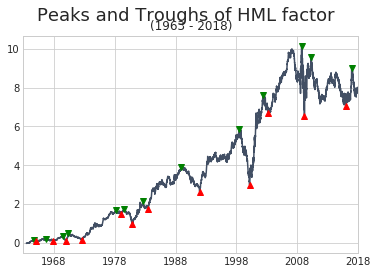

In [5]:
# Print a graph with peaks and troughs
peak = timeseries.loc[timeseries['ip']==1, 'ip'] * timeseries.loc[timeseries['ip']==1, 'price']
trough = (-1) * timeseries.loc[timeseries['ip']==-1, 'ip'] * timeseries.loc[timeseries['ip']==-1, 'price']

_ = plt.plot(timeseries['price'], color=my_colors['DBlue'])
_ = plt.plot(peak, 'v',color = 'green')
_ = plt.plot(trough, '^',color = 'red')
_ = plt.xlim('1963','2018')
_ = plt.suptitle('Peaks and Troughs of HML factor', fontsize=18)
_ = plt.title('(1963 - 2018)', fontsize= 12)


# Save the plot
plt.savefig('Graphs\HML_peaks_troughs.png', dpi=300)

To better visualize it, let's look at compound return in each phase of the Value cycle.

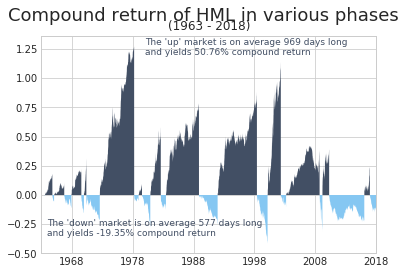

In [10]:
df_tmp = timeseries.copy()

df_tmp['ret'] = df['HML']/100

df_tmp.loc[df_tmp['ip']==0,'ip'] = np.nan
df_tmp.loc[np.isfinite(df_tmp['ip']),'ip'] = 0
df_tmp.loc[np.isnan(df_tmp['ip']),'ip'] = 1


buy_peak = pd.DataFrame(index=df_tmp.index) #Place holder for the dataframe

comp_ret=np.array([0.])
for i in range(1, len(df_tmp)):
    comp_ret_new = ((1 + comp_ret[i-1]) * (1 + df_tmp['ret'].iloc[i]) -1) * df_tmp['ip'].iloc[i]
    comp_ret = np.append(comp_ret, comp_ret_new)    

buy_peak['B_o_P'] = comp_ret

x = buy_peak.index
y = buy_peak['B_o_P']

_ = plt.fill_between(x, y, where= y >= 0, facecolor=my_colors['DBlue'])
_ = plt.fill_between(x, y, where= y < 0, facecolor=my_colors['BrBlue'])
_ = plt.xlim(('1963', '2018'))
_ = plt.suptitle('Compound return of HML in various phases', fontsize=18 )
_ = plt.title('(1963 - 2018)')


# Add annotation
# Divide into periods
df_tmp = cycles.copy()
df_tmp = df_tmp.join(buy_peak['B_o_P'].shift(1), how='left')
df_tmp.loc[df.index[0],'B_o_P'] = 0
df_tmp.loc[df.index[-1],'B_o_P'] = buy_peak['B_o_P'].iloc[-1]
df_tmp.sort_index(inplace=True)
df_tmp.reset_index(inplace=True)

# Calculate perdiod length
df_tmp['period'] = df_tmp['index'] - df_tmp['index'].shift(1)
df_tmp.set_index('index', inplace=True)
df_tmp = df_tmp.iloc[1:,]
df_tmp['period'] = (df_tmp['period']/ np.timedelta64(1, 'D')).astype(int)

# Calculate average period and return
period = df_tmp.groupby('ip')['period'].mean()
ret = df_tmp.groupby('ip')['B_o_P'].mean()

hml_stats = pd.DataFrame([period, ret]).T
hml_stats.index = ['Down', 'Up']
hml_stats.columns = ['Avg. period (days)', 'Avg. compound return']
hml_stats.iloc[:,0] = hml_stats.iloc[:,0].astype('int')
hml_stats.iloc[:,1] = hml_stats.iloc[:,1].round(4)

up = 'The \'up\' market is on average ' + str(hml_stats.iloc[1,0]) + ' days long\nand yields ' + str(round(hml_stats.iloc[1,1]*100, 2)) +'% compound return'
down = 'The \'down\' market is on average ' + str(hml_stats.iloc[0,0]) +' days long \nand yields ' + str(round(hml_stats.iloc[0,1]*100,2)) +'% compound return'

_ = plt.text('1980', 1.20, up, size=9, color=my_colors['DBlue'])
_ = plt.text('1964', -0.35, down, size=9, color=my_colors['DBlue'])

# Save the plot
plt.savefig('Graphs\HML_peaks_troughs_comp.png', dpi=300)

We can see that historically the Value cycles were longer and more profitable than the Growth cycles. However, things have changed in the recent decade. In my next blog post, I will present my view on the possible explanation of this phenomenon and on its potential impact on the stock market in the near future.

## Conclusion

We can create factor portfolios that provide risk/return exposure to certain desirable characteristics of stocks, e.g., Value investing, robust profitability, etc. These factor portfolios, aka “smart beta,” can be the basis for the investment strategy implemented by an asset manager.

Our quick analysis of the Value (HML) factor shows that historically Value cycles have been longer and yielded higher compound returns than Growth cycles.


## References

*1. Carhart, Mark M. "On persistence in mutual fund performance." The Journal of finance 52.1 (1997): 57-82.*

*2. Fama, Eugene F., and Kenneth R. French. "The cross‐section of expected stock returns." the Journal of Finance 47.2 (1992): 427-465.*

*3. Fama, Eugene F., and Kenneth R. French. "Incremental variables and the investment opportunity set." Journal of Financial Economics 117.3 (2015): 470-488.*

*4. Fung, William, and David A. Hsieh. "The risk in hedge fund strategies: Theory and evidence from trend followers." The Review of Financial Studies 14.2 (2001): 313-341.*

*5. Markowitz, Harry. "Portfolio selection." The journal of finance 7.1 (1952): 77-91.*

*6. Pagan, Adrian R., and Kirill A. Sossounov. "A simple framework for analysing bull and bear markets." Journal of Applied Econometrics 18.1 (2003): 23-46.*

*7. Sharpe, William F. "Capital asset prices: A theory of market equilibrium under conditions of risk." The journal of finance 19.3 (1964): 425-442.*



### Reminder

**If you choose to use this publication for your own work, please include a reference to this publication and a link leading to this document. **

### Disclaimer

**Not an Offer or Inducement**

*This publication has been prepared for informational purposes only and does not constitute an offer to sell, a solicitation of an offer to buy, or a recommendation of any security or any other product or service by QFL Capital LLC., QFL Holdings Inc., authors of the publication, or any other third party regardless of whether such security, product or service is referenced in this publication. None of the information or analyses presented are intended to form the basis for any investment decision, and no specific recommendations are intended.*

*Accordingly, this publication does not constitute investment advice or counsel or solicitation for investment in any security. This publication does not constitute or form part of, and should not be construed as, any offer for sale or subscription of, or any invitation to offer to buy or subscribe for, any securities, nor should it or any part of it form the basis of, or be relied on in any connection with, any contract or commitment whatsoever.*

*QFL Capital LLC., QFL Holdings Inc., and authors of the publication expressly disclaim any and all responsibility for any direct or consequential loss or damage of any kind whatsoever arising directly or indirectly from: (i) the use of this site; (ii) reliance on any information contained herein; (iii) any error, omission or inaccuracy in any such information; or (iv) any action resulting therefrom.*


**Investment Performance**

*Investors should seek financial advice regarding the appropriateness of investing in any securities or investment strategies discussed or recommended in this documentation and should understand that statements regarding future prospects may not be realized. Investors should note that income from such securities may fluctuate and that each security's price or value may rise or fall. Accordingly, investors may receive back less than originally invested.*

*Past performance is not necessarily a guide to future performance. In consideration of being permitted access to the publication, the viewer hereby acknowledges having read and understood this agreement and agrees to be bound by its terms and conditions.*

**No Warranties**

*QFL Capital LLC., QFL Holdings Inc., and authors of the publication take care to ensure that the information provided is accurate and up to date. However, this document is provided without warranties of any kind, either expressed or implied, including but not limited to warranties of title or implied warranties of merchantability or fitness for a particular purpose. Opinions expressed herein are subject to change without notice. All information and content on this publication is furnished "as is," without warranty of any kind, express or implied, including but not limited to implied warranties of merchantability, fitness for a particular purpose, or non-infringement.*